In [1]:
import networkx as nx
import numpy as np

G = nx.Graph()
blue, orange, green = "#1f77b4", "#ff7f0e", "#2ca02c"
G.add_nodes_from([(1, {"color": blue}),
                  (2, {"color": orange}),
                  (3, {"color": blue}),
                  (4, {"color": green})])
G.add_edges_from([(1, 2), (2, 3), (1, 3), (3, 4)])
A = np.asarray(nx.adjacency_matrix(G).todense())
print(A)

[[0 1 1 0]
 [1 0 1 0]
 [1 1 0 1]
 [0 0 1 0]]


In [2]:
def build_graph_color_label_representation(G, mapping_dict):
    one_hot_idxs = np.array([mapping_dict[v] for v in nx.get_node_attributes(G, 'color').values()])
    one_hot_encoding = np.zeros((one_hot_idxs.size, len(mapping_dict)))
    one_hot_encoding[np.arange(one_hot_idxs.size), one_hot_idxs] = 1
    return one_hot_encoding


X = build_graph_color_label_representation(G, {green: 0, blue: 1, orange: 2})
print(X)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


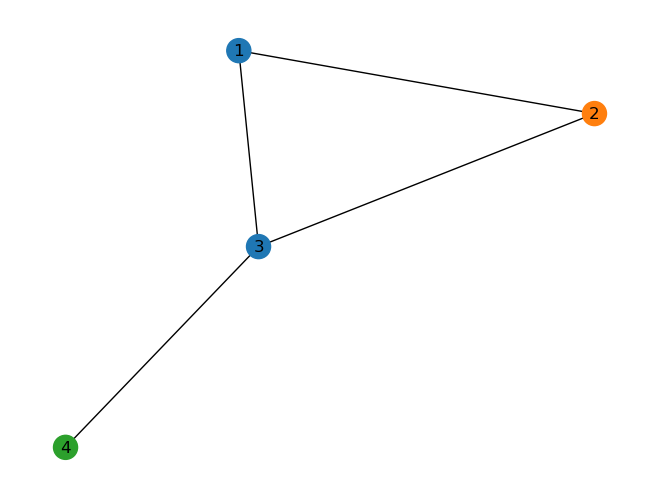

In [3]:
color_map = nx.get_node_attributes(G, 'color').values()
nx.draw(G, with_labels=True, node_color=color_map)

In [4]:
f_in, f_out = X.shape[1], 6
W_1 = np.random.rand(f_in, f_out)
W_2 = np.random.rand(f_in, f_out)
h = np.dot(X, W_1) + np.dot(np.dot(A, X), W_2)

In [5]:
import networkx as nx
import torch
from torch.nn.parameter import Parameter
import numpy as np
import torch.nn.functional as F


class NodeNetwork(torch.nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.conv_1 = BasicGraphConvolutionLayer(input_features, 32)
        self.conv_2 = BasicGraphConvolutionLayer(32, 32)
        self.fc_1 = torch.nn.Linear(32, 16)
        self.out_layer = torch.nn.Linear(16, 2)

    def forward(self, X, A, batch_mat):
        x = self.conv_1(X, A).clamp(0)
        x = self.conv_2(x, A).clamp(0)
        output = global_sum_pool(x, batch_mat)
        output = self.fc_1(output)
        output = self.out_layer(output)
        return F.softmax(output, dim=1)

In [6]:
class BasicGraphConvolutionLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.W2 = Parameter(torch.rand((in_channels, out_channels), dtype=torch.float32))
        self.W1 = Parameter(torch.rand((in_channels, out_channels), dtype=torch.float32))

        self.bias = Parameter(torch.zeros(out_channels, dtype=torch.float32))

    def forward(self, X, A):
        potential_msgs = torch.mm(X, self.W2)
        propagated_msgs = torch.mm(A, potential_msgs)
        root_update = torch.mm(X, self.W1)
        output = propagated_msgs + root_update + self.bias
        return output

In [7]:
def global_sum_pool(X, batch_mat):
    if batch_mat is None or batch_mat.dim() == 1:
        return torch.sum(X, dim=0).unsqueeze(0)
    else:
        return torch.mm(batch_mat, X)

In [8]:
def get_batch_tensor(graph_sizes):
    starts = [sum(graph_sizes[:idx]) for idx in range(len(graph_sizes))]
    stops = [starts[idx] + graph_sizes[idx] for idx in range(len(graph_sizes))]
    tot_len = sum(graph_sizes)
    batch_size = len(graph_sizes)
    batch_mat = torch.zeros([batch_size, tot_len]).float()
    for idx, starts_and_stops in enumerate(zip(starts, stops)):
        start = starts_and_stops[0]
        stop = starts_and_stops[1]
        batch_mat[idx, start:stop] = 1
    return batch_mat

In [9]:
def collate_graphs(batch):
    adj_mats = [graph['A'] for graph in batch]
    sizes = [A.size(0) for A in adj_mats]
    tot_size = sum(sizes)
    batch_mat = get_batch_tensor(sizes)
    feat_mats = torch.cat([graph['X'] for graph in batch], dim=0)
    labels = torch.cat([graph['y'] for graph in batch], dim=0)
    batch_adj = torch.zeros([tot_size, tot_size], dtype=torch.float32)
    accum = 0
    for adj in adj_mats:
        g_size = adj.shape[0]
        batch_adj[accum:accum + g_size, accum:accum + g_size] = adj
        accum = accum + g_size
    repr_and_label = {'A': batch_adj, 'X': feat_mats, 'y': labels, 'batch': batch_mat}

    return repr_and_label

In [10]:
def get_graph_dict(G, mapping_dict):
    A = torch.from_numpy(np.asarray(nx.adjacency_matrix(G).todense())).float()
    X = torch.from_numpy(build_graph_color_label_representation(G, mapping_dict)).float()
    y = torch.tensor([[1, 0]]).float()
    return {'A': A, 'X': X, 'y': y, 'batch': None}


blue, orange, green = "#1f77b4", "#ff7f0e", "#2ca02c"
mapping_dict = {green: 0, blue: 1, orange: 2}
G1 = nx.Graph()
G1.add_nodes_from([(1, {"color": blue}),
                   (2, {"color": orange}),
                   (3, {"color": blue}),
                   (4, {"color": green})])
G1.add_edges_from([(1, 2), (2, 3), (1, 3), (3, 4)])
G2 = nx.Graph()
G2.add_nodes_from([(1, {"color": green}),
                   (2, {"color": green}),
                   (3, {"color": orange}),
                   (4, {"color": orange}),
                   (5, {"color": blue})])
G2.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1)])
G3 = nx.Graph()
G3.add_nodes_from([(1, {"color": orange}),
                   (2, {"color": orange}),
                   (3, {"color": green}),
                   (4, {"color": green}),
                   (5, {"color": blue}),
                   (6, {"color": orange})])
G3.add_edges_from([(2, 3), (3, 4), (3, 1), (5, 1), (2, 5), (6, 1)])
G4 = nx.Graph()
G4.add_nodes_from([(1, {"color": blue}), (2, {"color": blue}), (3, {"color": green})])
G4.add_edges_from([(1, 2), (2, 3)])
graph_list = [get_graph_dict(graph, mapping_dict) for graph in [G1, G2, G3, G4]]

In [11]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class ExampleDataset(Dataset):
    def __init__(self, graph_list):
        self.graphs = graph_list

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        mol_rep = self.graphs[idx]
        return mol_rep

In [12]:
dset = ExampleDataset(graph_list)
loader = DataLoader(dset, batch_size=2, shuffle=False, collate_fn=collate_graphs)

In [13]:
torch.manual_seed(123)
node_features = 3
net = NodeNetwork(node_features)

In [14]:
batch_results = []
for b in loader:
    batch_results.append(net(b['X'], b['A'], b['batch']).detach())

G1_rep = dset[1]
G1_single = net(G1_rep['X'], G1_rep['A'], G1_rep['batch']).detach()
G1_batch = batch_results[0][1]
torch.all(torch.isclose(G1_single, G1_batch))

tensor(True)

In [15]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
import numpy as np

dset = QM9('.')
len(dset)

Extracting ./raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


130831

In [16]:
data = dset[0]
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

In [17]:
data.z

tensor([6, 1, 1, 1, 1])

In [18]:
data.new_attribute = torch.tensor([1, 2, 3])
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], new_attribute=[3])

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
data.to(device)
data.new_attribute.is_cuda

False

In [21]:
class ExampleNet(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(nn.Linear(num_edge_features, 32),
                                  nn.ReLU(),
                                  nn.Linear(32, num_node_features * 32))
        conv2_net = nn.Sequential(nn.Linear(num_edge_features, 32),
                                  nn.ReLU(),
                                  nn.Linear(32, 32 * 16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32, 16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)

    def forward(self, data):
        batch, x, edge_index, edge_attr = data.batch, data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x, batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

In [22]:
from torch.utils.data import random_split

train_set, valid_set, test_set = random_split(dset, [110000, 10831, 10000])
trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [23]:
qm9_node_feats, qm9_edge_feats = 11, 4
epochs = 4
net = ExampleNet(qm9_node_feats, qm9_edge_feats)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 4
target_idx = 1

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [25]:
for total_epochs in range(epochs):
    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()

    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs

    print(f"에포크 : {total_epochs} | 훈련 평균 손실 : {train_avg_loss:.2f} | 검증 평균 손실 : {val_avg_loss:.2f}")

에포크 : 0 | 훈련 평균 손실 : 0.39 | 검증 평균 손실 : 0.21
에포크 : 1 | 훈련 평균 손실 : 0.13 | 검증 평균 손실 : 0.36
에포크 : 2 | 훈련 평균 손실 : 0.11 | 검증 평균 손실 : 0.07
에포크 : 3 | 훈련 평균 손실 : 0.09 | 검증 평균 손실 : 0.05


In [26]:
net.eval()
predictions = []
real = []

for batch in testloader:
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:, target_idx].detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

Text(0.5, 0, 'Isotropic polarizability')

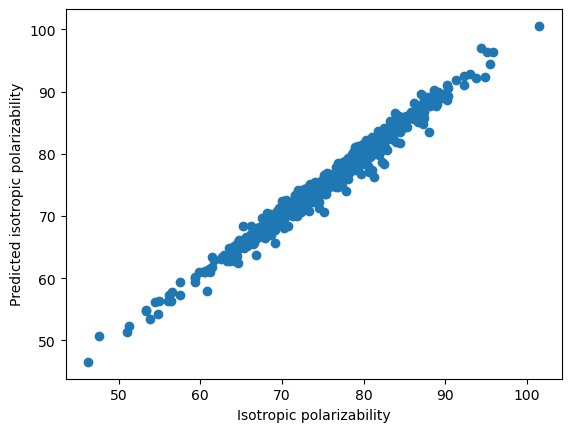

In [27]:
import matplotlib.pyplot as plt

plt.scatter(real[:500], predictions[:500])
plt.ylabel('Predicted isotropic polarizability')
plt.xlabel('Isotropic polarizability')